# Analysing the Local Galaxy
### Data Importing
Now, let's actually start quantitatively analysing some data. First thing's first; let's import some data. I'm going to use the python package `pandas` to import and store the data.

In [4]:
import pandas as pd

datapath = 'Sim Data (Clusters=1000, Seed=588)' # all of the data is within a folder in this .ipynb file's directory
stardata = pd.read_csv(datapath + '/Star Data.txt', delimiter=' ')    # read the data from the .txt file into a dataframe

equats = stardata['Equatorial']    # get the equatorial positions of all of the stars
polars = stardata['Polar']     # get the polar positions of all of the stars
parallax = stardata['Parallax']    # get the parallax of the stars


### Plotting the Local Galaxy
Now with the data imported, let's take a look at all of the stars that are nearby to us. 
The output data includes parallax angles, so it's a really simple task to separate data with non-negligible parallax data and then plot it. 

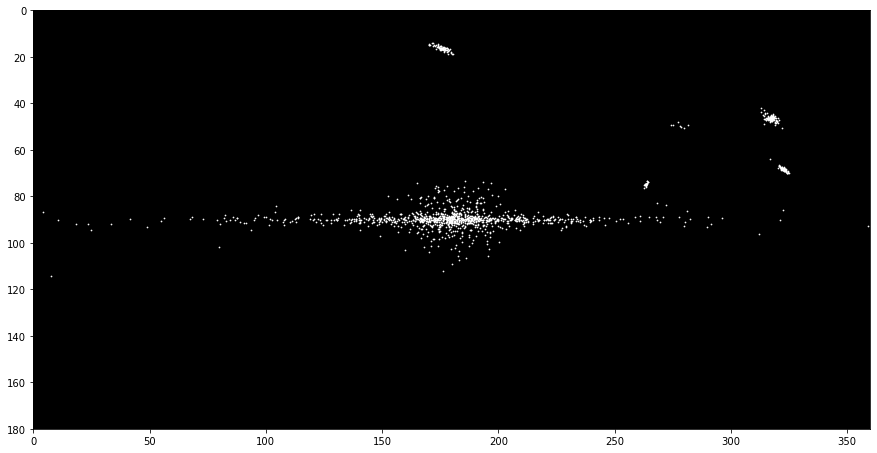

In [5]:
# now, lets plot all of the stars that have some parallax angle
import matplotlib.pyplot as plt

indexes = [i for i, x in enumerate(parallax) if x > 0.001]   # this will return the indexes of all stars that have some parallax
# now to populate new lists with all of the equatorial/polar angles of stars that have some parallax
localequats = [equats[i] for i in indexes]  
localpolars = [polars[i] for i in indexes]

# now lets plot these close stars!
fig = plt.figure(figsize=(15, 15))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(localequats, localpolars, s=0.5, c='w')  # plot small-ish dots, all white in colour
ax.set_xlim([0, 360]) # we go 0->360 degrees equatorially
ax.set_ylim([0, 180]) # we go 0->180 degrees along the poles
ax.invert_yaxis()  # the data is set up so that polar angle of 0 is at the top, so we need to flip the axis
ax.set_facecolor('k')   # space has a black background, duh
ax.set_aspect(1)    # makes it so that the figure is twice as wide as it is tall - no stretching!
plt.show()   # now, finally show the figure

This looks really cool! We can see a horizontal band of stars as we'd expect from our local galaxy. We can also see some not-too-distant galaxies to the top right of the picture.

### Determining Variable Star Properties
Now, let's take a look at the stars that have some variability AND parallax data. Firstly, lets get the names and rough luminosities (in the V band) of each star, where luminosity is calculated by

$$ L = F \times r^2$$

In [6]:
import numpy as np

variables = stardata["Variable?"]
variableindexes = [i for i, x in enumerate(parallax) if x > 0.005 and variables[i] == 1] # we only want stars that are pretty close!
starnames = stardata['Name']; starnames = [i for i in starnames]
variablenames = [starnames[i] for i in variableindexes]
variableparallaxes = np.array([stardata["Parallax"][i] for i in variableindexes])

Vfluxes = stardata['GreenF']; variableVfluxes = np.array([Vfluxes[i] for i in variableindexes])
variableVlumins = variableVfluxes * ((1 / variableparallaxes) * 3.086 * 10**16)**2

Now we've got some luminosities. Let's work out what the period of these light curves are.
#### Calculating Periods from Timeseries Data
This can be a simple job to do by hand for one or two lightcurves, but doing it accurately across potentially thousands of lightcurves can be difficult. There are several ways that you *could* do this. The way most familiar to me is to use a Lomb Scargle periodogram. Let's start by importing some packages and seeing how we find the period of one star.

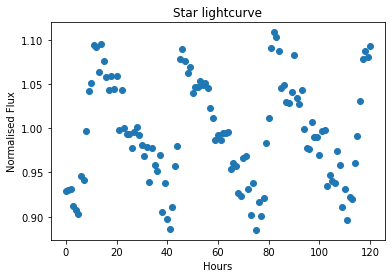

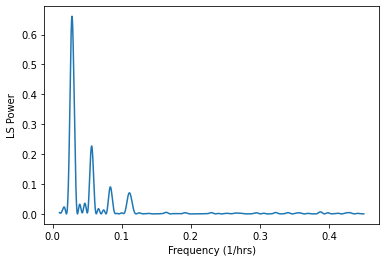

Most likely period: 35.49 h


In [27]:
from astropy.timeseries import LombScargle
from glob import glob

variablepath = datapath + "/Variable Star Data/"
fnames = glob(variablepath + "*.txt")
freqs = np.linspace(1/100, 0.45, 10000) # frequency grid shouldn't go higher than Nyquist limit

for lightcurve in fnames[-1:]: # I had to do it in reverse to avoid the first entry being anomalous data! Dont include the [-1:] in your analysis
    if lightcurve[len(variablepath):-4] in variablenames: # this checks whether the star of this lightcurve is in our variable stars
        data = pd.read_csv(lightcurve, delimiter=' ') # load in the data
        time, flux = data['Time'], data['NormalisedFlux'] # just extract the columns as variables
        plt.scatter(time, flux); plt.title('Star lightcurve'); plt.xlabel('Hours'); plt.ylabel('Normalised Flux'); plt.show()
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle
        power = LS.power(freqs) # calculate LS power 
        plt.plot(freqs, power); plt.xlabel('Frequency (1/hrs)'); plt.ylabel('LS Power')
        plt.show()
        print('Most likely period: %.2f h' % (1 / freqs[np.argmax(power)]))
        break

This looks excellent! We can clearly see (top graph) that this star has a well defined period in a saw-tooth like wave. When we perform some analysis on the data, the Lomb Scargle fitting shows that there are four dominant sine curves that make up the overall light curve, with the first one having the largest contribution. This results in the most likely period (the frequency position of the first and largest peak) being about 35.5 hours.

(side note: this shows a lot about how I actually simulated the data - oops!)

In any case, we can now do this analysis across all of the nearby variable stars to approximate their periods.

In [7]:
periods = []   # initialise a list to hold all of our period data

for lightcurve in fnames:
    if lightcurve[len(variablepath):-4] in variablenames: # this checks whether the star of this lightcurve is in our variable stars
        data = pd.read_csv(lightcurve, delimiter=' ') # load in the data
        time, flux = data['Time'], data['NormalisedFlux'] # just extract the columns as variables
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle fitting
        power = LS.power(freqs) # calculate LS power 
        bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
        pred = LS.model(time, bestfreq) # make a sine wave prediction at the best frequency
        periods.append(1 / bestfreq) # add each period to the list
    
periods = np.array(periods) # turn it from a list to an array

Now with that done, we can plot the data and see where our variable stars lie on a period-luminosity graph.

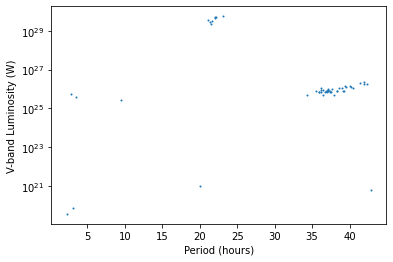

In [8]:
fig, ax = plt.subplots()
ax.scatter(periods, variableVlumins, s=1)
ax.set_yscale('log')
ax.set_xlabel('Period (hours)')
ax.set_ylabel('V-band Luminosity (W)');

We can see some noisy data scattered mostly to the left which we can ignore. What's left seems to be two nicely defined (likely linear!) trends in period and log luminosity. 
#### Calculating Period-Luminosity Functions
Time to work out the period luminosity relations, starting with the lower period relation...

Short grad = 0.16614628474437435 Short y-int = 25.97081865286683


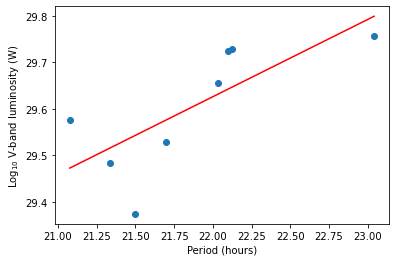

In [13]:
lowperiodindexes = [i for i, x in enumerate(periods) if 15 <= x <= 30]
# we need to do another step to remove the outlier(s) at the bottom. Check to see if lumins for each index are high
# enough luminosity:
lowperiodindexes = [lowperiodindexes[i] for i, x in enumerate(variableVlumins[lowperiodindexes]) if x > 10**25]
lowperiods = periods[lowperiodindexes]
lowperiodlumins = np.log10(variableVlumins[lowperiodindexes]) # get lumins in log scale

# now, lets fit a linear trend to this data. We can do this with a polynomial fit of one degree from numpy:
shortgradient, shortyint = np.polyfit(lowperiods, lowperiodlumins, 1)
print("Short grad =", shortgradient, "Short y-int =", shortyint)
fitperiods = np.linspace(min(lowperiods), max(lowperiods), 10)
fitlumins = shortgradient * fitperiods + shortyint

fig, ax = plt.subplots()
ax.scatter(lowperiods, lowperiodlumins);
ax.plot(fitperiods, fitlumins, 'r-')
ax.set_xlabel('Period (hours)'); ax.set_ylabel(r'Log$_{10}$ V-band luminosity (W)');


This gives a reasonably close and consistent fit with the data, with a trendline of approximately 

$$\text{Log}_{10}(L) = 0.166P + 25.97$$

Now we should do the same with the longer period data:

Longer grad = 0.07057924922426316 Longer y-int = 23.28437494141718


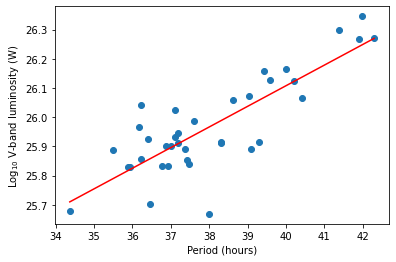

In [15]:
longerperiodindexes = [i for i, x in enumerate(periods) if 30 <= x <= 50]
# we need to do another step to remove the outlier(s) at the bottom. Check to see if lumins for each index are high
# enough luminosity:
longerperiodindexes = [longerperiodindexes[i] for i, x in enumerate(variableVlumins[longerperiodindexes]) if x > 10**23]
longerperiods = periods[longerperiodindexes]
longerperiodlumins = np.log10(variableVlumins[longerperiodindexes]) # get lumins in log scale

# now, lets fit a linear trend to this data. We can do this with a polynomial fit of one degree from numpy:
longergradient, longeryint = np.polyfit(longerperiods, longerperiodlumins, 1)
print("Longer grad =", longergradient, "Longer y-int =", longeryint)
fitperiods = np.linspace(min(longerperiods), max(longerperiods), 10)
fitlumins = longergradient * fitperiods + longeryint

fig, ax = plt.subplots()
ax.scatter(longerperiods, longerperiodlumins);
ax.plot(fitperiods, fitlumins, 'r-')
ax.set_xlabel('Period (hours)'); ax.set_ylabel(r'Log$_{10}$ V-band luminosity (W)');

This trendline gives a fit of approximately 

$$\text{Log}_{10}(L) = 0.071P + 23.28$$

This seems like quite a strong trend! Longer period stars appear to have much closer alignment to their linear trends. This is good because it allows us to accurately determine the distance to closer variable stars, but is disappointing that this longer period trend only applies to dimmer stars (so we can't use it for very distant resolved stars!).

### Plotting a HR Diagram

Now, lets see if these variable stars belong to a certain point on a HR diagram. 

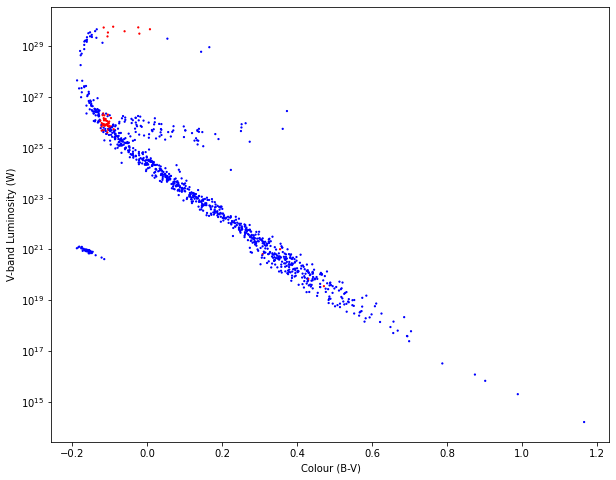

In [12]:
localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(stardata["GreenF"])[localindex]
localBflux = np.array(stardata["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux)

localVlumin = localVflux * (1 / np.array(stardata["Parallax"][localindex]) * 3.086 * 10**16)**2

localvariables = stardata["Variable?"][localindex]
colours = ['r' if var==1 else 'b' for var in localvariables] # this means variable stars are red, normal stars are blue

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(BV, localVlumin, s=1.5, c=colours)
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

Excellent! We can clearly see that each class of variable star belongs to a certain position on a HR diagram. We can also see a whole host of features about stars in our local neighbourhood. One thing worth mentioning is that this is an *observational* HR diagram in that nothing has *really* been done to the values here, and so we can be pretty confident in the position of all of the stars. 

Finally, let's try to work out some stuff about the stars in our local galaxy. 

### Finding Star Temperatures
